# Simplified Direct Sampling aka Direct Sampling Best Candidate (DSBC)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ot

from geone import img
from geone import imgplot
from geone import deesseinterface

In [2]:
%load_ext autoreload
%autoreload 1
%aimport ensemble, simulator, scoring

## Test 2. Continuous with pyramides.

In [3]:
bedmap = np.fromfile('bedmap2/bedmap2_bin/bedmap2_bed.flt', dtype='float32')
bedmap = bedmap.reshape((6667, 6667))

In [4]:
uncertain = np.fromfile('bedmap2/bedmap2_bin/bedmap2_grounded_bed_uncertainty.flt', dtype='float32')
uncertain = uncertain.reshape((6667, 6667))

In [21]:
bedmap[uncertain==1000] = -9999
bedmap[bedmap==-9999] = np.nan

In [11]:
bedmap[np.newaxis, np.newaxis].shape

(1, 1, 6667, 6667)

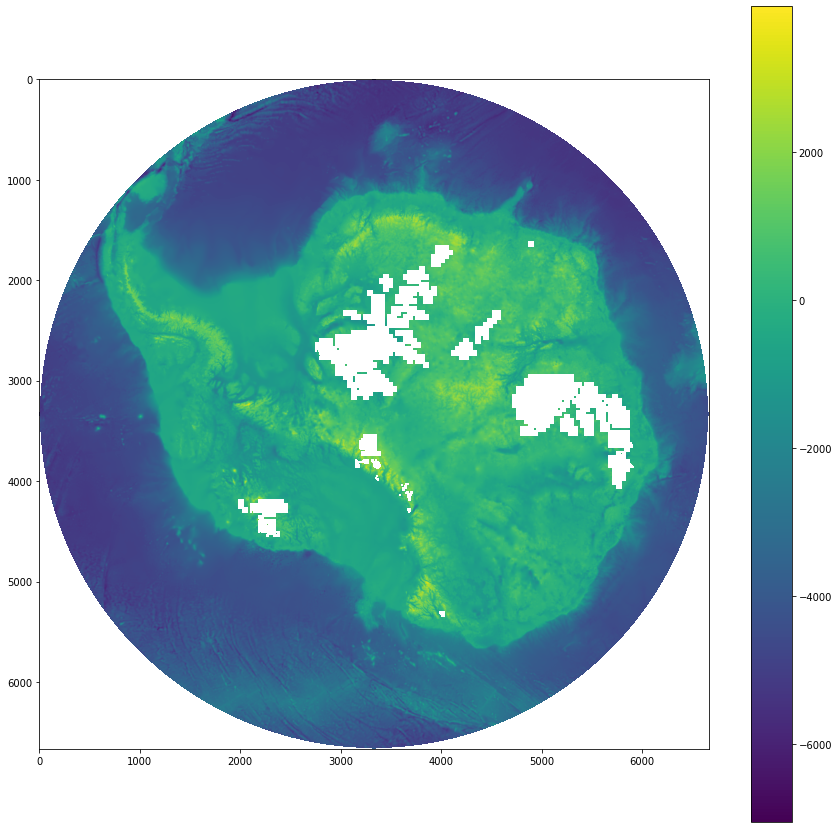

In [34]:
plt.figure(figsize=(15,15))
plt.imshow(bedmap)
plt.colorbar()

In [36]:
ti = img.Img(nx=bedmap.shape[1], ny=bedmap.shape[0], nz=1, nv=1, sx=1, sy=1, sz=1, ox=0, val=np.flipud(bedmap)[np.newaxis, np.newaxis])

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7f2d108cb820>)

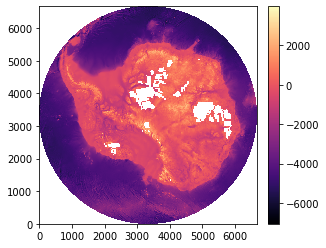

In [38]:
imgplot.drawImage2D(ti, cmap='magma')

In [39]:
import copy

In [40]:
def cut_square(ox, oy, range_x, range_y):
    new_ti = copy.copy(ti)
    new_ti.val[:,:,oy:oy+range_y, ox:ox+range_y] = np.nan
    return new_ti
    

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7f2d106bf190>)

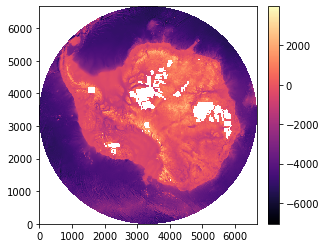

In [43]:
new_ti = cut_square(1500, 4000, 200, 200)
imgplot.drawImage2D(new_ti, cmap='magma')

In [49]:
def sim_grid(ox, oy, range_x, range_y):
    grid = cut_square(ox, oy, range_x, range_y)
    grid.resize(ix0=ox-range_x//2, ix1=ox+ 3*range_x//2, iy0=oy-range_y//2, iy1=oy+3*range_y//2)
    return grid

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7f2cd99de640>)

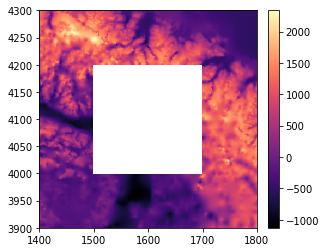

In [50]:
grid = sim_grid(1500, 4000, 200, 200)
imgplot.drawImage2D(grid, cmap='magma')

In [45]:
?ti.resize

Signature:
ti.resize(
    ix0=0,
    ix1=None,
    iy0=0,
    iy1=None,
    iz0=0,
    iz1=None,
    iv0=0,
    iv1=None,
    newval=nan,
    newvarname='',
)
Docstring:
Resizes the image.
According to the x(, y, z) direction, the slice from ix0 to ix1-1
(iy0 to iy1-1, iz0 to iz1-1) is considered (if None, ix1(, iy1, iz1)
is set to nx(, ny, nz)), deplacing the origin from ox(, oy, oz)
to ox+ix0*sx(, oy+iy0*sy, oz+iz0*sz), and inserting value newval at
possible new locations:

:param ix0, ix1:    (int or None) indices for x direction ix0 < ix1
:param iy0, iy1:    (int or None) indices for y direction iy0 < iy1
:param iz0, iz1:    (int or None) indices for z direction iz0 < iz1
:param iv0, iv1:    (int or None) indices for v direction iv0 < iv1
:param newval:      (float) new value to insert at possible new location
:param newvarname:  (string) prefix for new variable name(s)
File:      ~/sim/simplified-ds/venv/lib/python3.8/site-packages/geone/img.py
Type:      method


In [36]:
plt.figure(figsize=(15,15))
uncertain[uncertain==1000] = -9999


<Figure size 1080x1080 with 0 Axes>

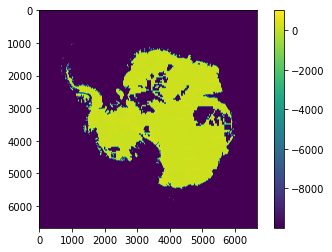

In [37]:
plt.imshow(uncertain)
plt.colorbar()

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7f6857d76190>)

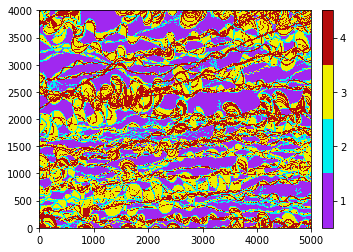

In [3]:
ti = img.readImageGslib('data/ti_4cat_wl375_2.gslib')
imgplot.drawImage2D(ti, categ=True)

In [4]:
ref_ensemble = ensemble.Ensemble.from_ti(ti=ti,
                                         x_size=200,
                                         y_size=200,
                                         size=400,
                                         seed=123)

In [5]:
TI = ensemble.SingleRealization.from_image(ti)

In [6]:
proportions_ensemble = ref_ensemble.proportions_ensemble()
proportions_TI = TI.proportions_ensemble()

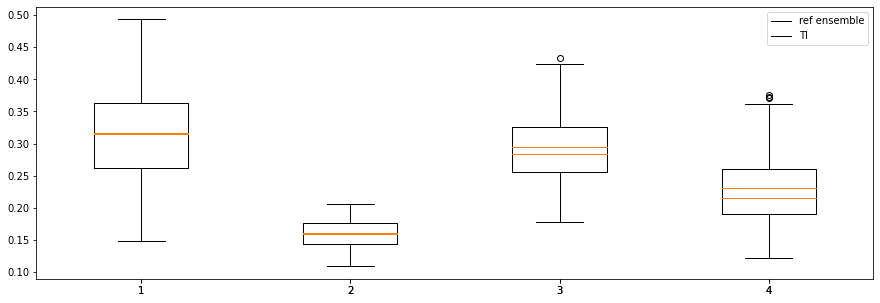

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.boxplot([proportions_ensemble[c] for c in ref_ensemble.categories])
ax.boxplot([proportions_TI[c] for c in TI.categories])
ax.legend(['ref ensemble', 'TI'])
plt.show()

In [8]:
quantiles = [0.25, 0.5, 0.75]
connectivity_quantiles = ref_ensemble.connectivity_quantiles(quantiles=quantiles)
connectivity_TI = TI.connectivities_ensemble()

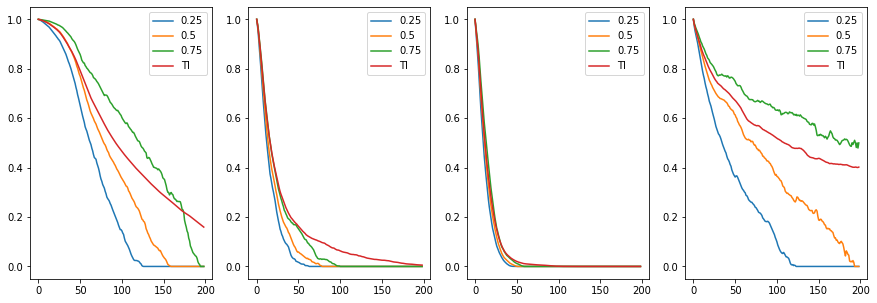

In [9]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(15,5))
for i, category in enumerate(connectivity_quantiles):
    for curve, quant in zip(connectivity_quantiles[category], quantiles):
        axes[i].plot(curve, label=str(quant))
    axes[i].plot(connectivity_TI[category][0][:199], label='TI')
    axes[i].legend()

In [10]:
quantiles = [0.25, 0.5, 0.75]
variogram_quantiles = ref_ensemble.variogram_quantiles(quantiles=quantiles)
variogram_TI = TI.variograms_ensemble()

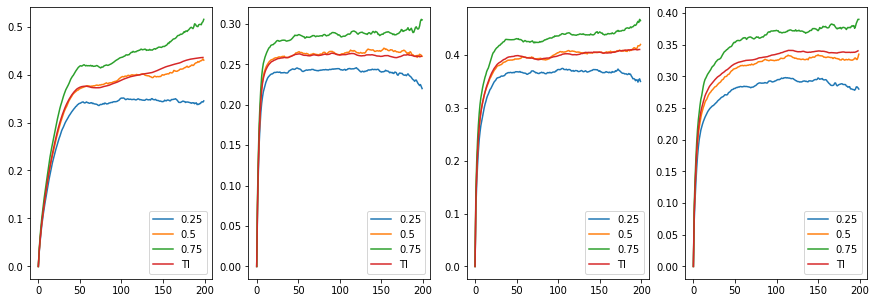

In [11]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(15,5))
for i, category in enumerate(variogram_quantiles):
    for curve, quant in zip(variogram_quantiles[category], quantiles):
        axes[i].plot(curve, label=str(quant))
    axes[i].plot(variogram_TI[category][0][:199], label='TI')
    axes[i].legend()

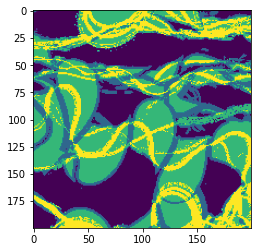

In [12]:
plt.imshow(ref_ensemble.members[0])

In [13]:
def load_ensembles(row, simulator_class):
    simulator_obj = simulator_class(nneighboringNode=row['nneighboringNode'],
                 distanceThreshold=row['distanceThreshold'],
                 maxScanFraction=row['maxScanFraction'],
                 root_dir='ds')
    
    ensemble, timing = simulator_obj.get_ensemble(ti, ensemble_size=40, nthreads=40, seed=444, overwrite=True)
    row['time'] = timing
    row['ensemble_size'] = ensemble.size
    
    comparator = scoring.EnsembleComparator(ensemble, ref_ensemble)
    row['ot_proportions'] = comparator.ot_proportions()
    row['ot_connectivity'] = comparator.ot_connectivity()
    row['ot_variogram'] = comparator.ot_variogram()
    
    ti_comparator = scoring.EnsembleToReferenceComparator(ensemble, TI)
    row['crps_proportions'] = ti_comparator.crps_proportions()
    row['crps_connectivity'] = ti_comparator.crps_connectivity()
    row['crps_variogram'] = ti_comparator.crps_variogram()
    
    return row

In [14]:
parameter_sets = [ [n, i/n] for n in [8, 16, 32, 64] for i in range(1, n//4 +1)]

df_ds_parameters = pd.DataFrame(parameter_sets, columns = ['nneighboringNode', 'distanceThreshold'])
df_ds_parameters['maxScanFraction'] = 0.25
df_ds_parameters.head()

df_ds_parameters

,nneighboringNode,distanceThreshold,maxScanFraction
0,8,0.125000,0.25
1,8,0.250000,0.25
2,16,0.062500,0.25
3,16,0.125000,0.25
4,16,0.187500,0.25
5,16,0.250000,0.25
6,32,0.031250,0.25
7,32,0.062500,0.25
8,32,0.093750,0.25
9,32,0.125000,0.25


In [15]:
%%time
try:
    df_ds = pd.read_csv('df_ds.csv', index_col=0)
except FileNotFoundError:
    # only reading without simulation: 11 min
    df_ds = df_ds_parameters.apply(lambda row: load_ensembles(row, simulator.DS), axis=1)
    df_ds.to_csv('df_ds.csv')
df_ds.head()

Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [V

,nneighboringNode,distanceThreshold,maxScanFraction,time,ensemble_size,ot_proportions,ot_connectivity,ot_variogram,crps_proportions,crps_connectivity,crps_variogram
0,8.0,0.1250,0.25,129.887071,40.0,0.003716,0.022746,0.005126,0.039836,0.086538,0.044889
1,8.0,0.2500,0.25,88.621959,40.0,0.006270,0.026524,0.007604,0.055298,0.120838,0.058818
2,16.0,0.0625,0.25,410.775545,40.0,0.000239,0.005569,0.000336,0.010946,0.055157,0.014524
3,16.0,0.1250,0.25,269.496509,40.0,0.002874,0.013744,0.003312,0.034942,0.060552,0.034625
4,16.0,0.1875,0.25,125.249846,40.0,0.013081,0.020053,0.011962,0.076138,0.077986,0.074484


In [16]:
f_values = [1/i for i in [8, 16, 32, 64, 128, 256]]
n_values = [8, 16, 32, 64]
n_column = [i for i in n_values for j in f_values]
f_column = [j for i in n_values for j in f_values]


df_dsbc_parameters = pd.DataFrame({'nneighboringNode': n_column,
                     'maxScanFraction': f_column})
df_dsbc_parameters['distanceThreshold'] = 0
df_dsbc_parameters.head()

,nneighboringNode,maxScanFraction,distanceThreshold
0,8,0.125000,0
1,8,0.062500,0
2,8,0.031250,0
3,8,0.015625,0
4,8,0.007812,0


In [17]:
%%time
try:
    df_dsbc = pd.read_csv('df_dsbc.csv', index_col=0)
except FileNotFoundError:
    df_dsbc = df_dsbc_parameters.apply(lambda row: load_ensembles(row, simulator.DSBC), axis=1)
    df_dsbc.to_csv('df_dsbc.csv')
df_dsbc.head()

Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 40 thread(s)]
Deesse run complete
Deesse running... [V

,nneighboringNode,maxScanFraction,distanceThreshold,time,ensemble_size,ot_proportions,ot_connectivity,ot_variogram,crps_proportions,crps_connectivity,crps_variogram
0,8.0,0.125000,0.0,596.812558,40.0,0.000655,0.014538,0.000985,0.016301,0.078555,0.019565
1,8.0,0.062500,0.0,354.630691,40.0,0.000743,0.015447,0.001073,0.016862,0.078861,0.020420
2,8.0,0.031250,0.0,194.485949,40.0,0.002384,0.026147,0.004377,0.032374,0.092491,0.039862
3,8.0,0.015625,0.0,119.426028,40.0,0.005932,0.036224,0.007719,0.050022,0.093754,0.055680
4,8.0,0.007812,0.0,175.668396,40.0,0.006820,0.037183,0.008455,0.053973,0.092971,0.059542
